# Analysis of Alternative Feature Sets

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import svm

%matplotlib inline

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
REGULATORS = DF_X.columns.tolist()
DATA_PATH = cn.PROJECT_DIR
for directory in ["data", "feature_analyzer"]:
    DATA_PATH = os.path.join(DATA_PATH, directory)
DATA_PATH_PAT = os.path.join(DATA_PATH, "%d") 
ANALYZER_DCT = feature_analyzer.deserialize({s: DATA_PATH_PAT % s for s in STATES})
ANALYZERS = ANALYZER_DCT.values()
COLLECTION_DCT = {s: feature_set_collection.FeatureSetCollection.deserialize(DATA_PATH_PAT % s) for s in STATES}
_ = [c.ser_comb for c in COLLECTION_DCT.values()]

In [3]:
def plotProfile(state, count=3):
    collection = COLLECTION_DCT[state]
    collection.plotProfileInstance(collection.ser_comb.index.tolist()[0:count], figsize=(16, 10))

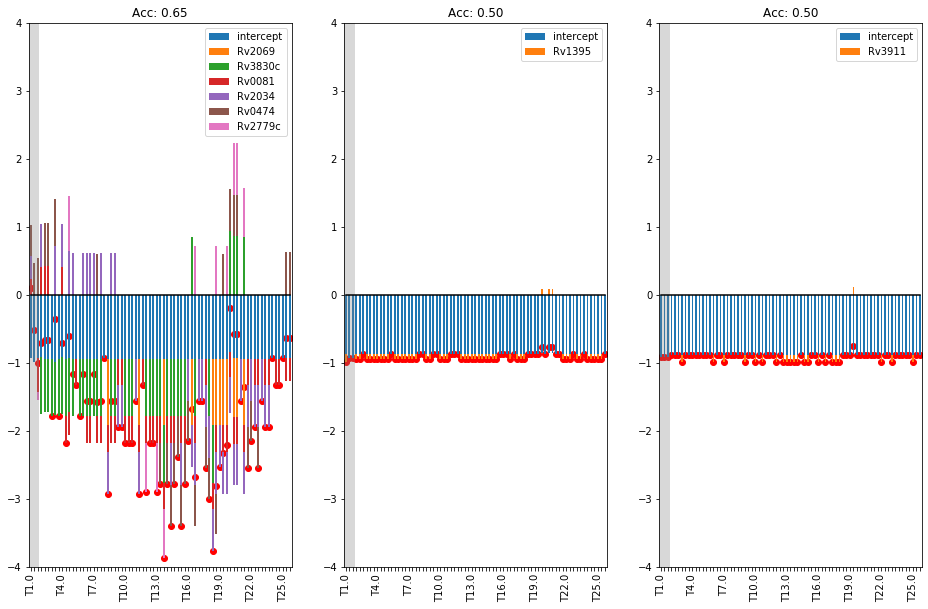

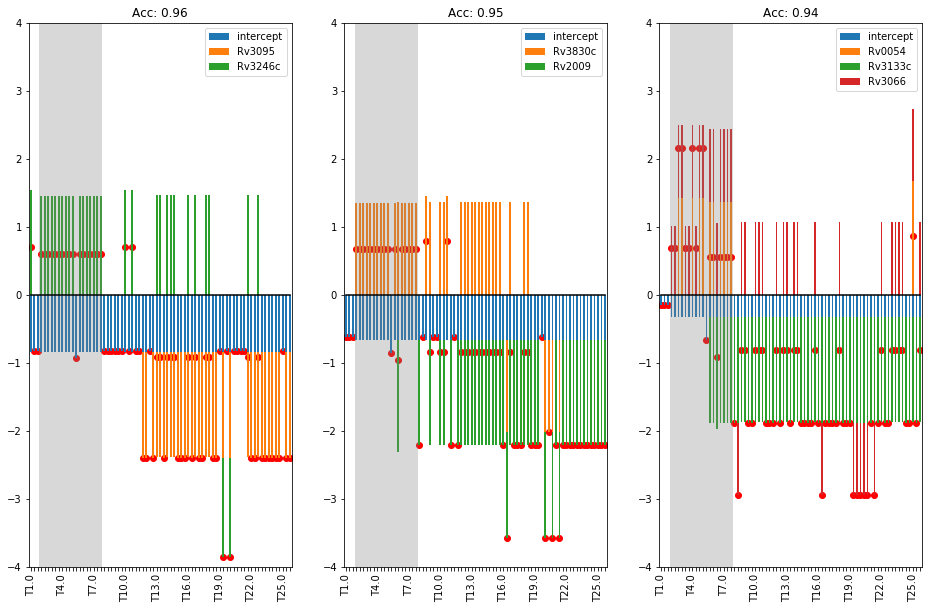

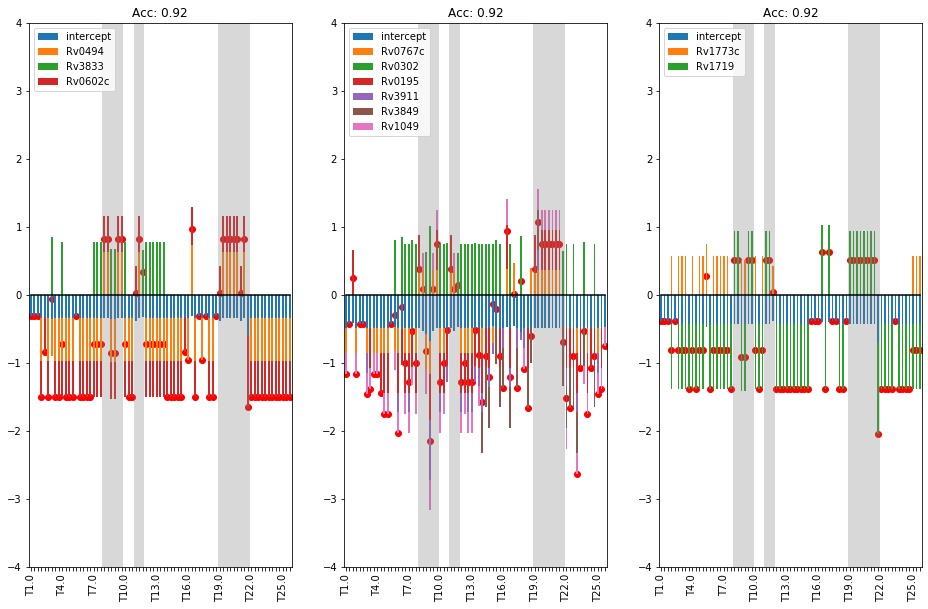

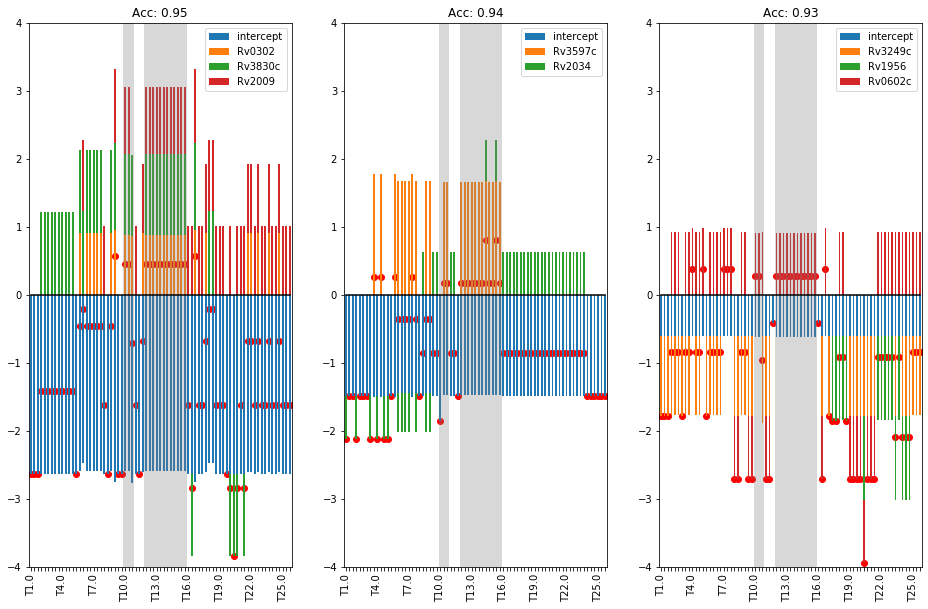

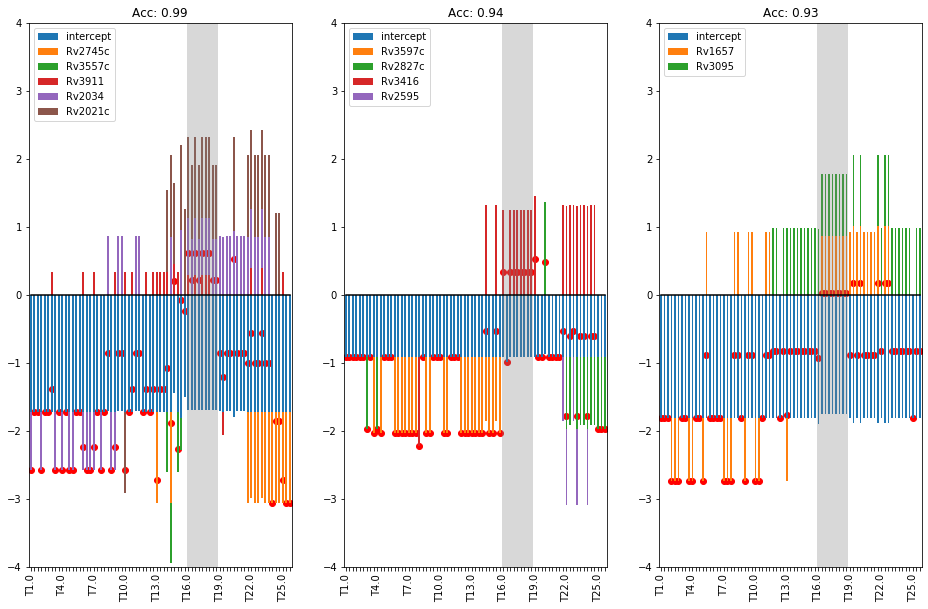

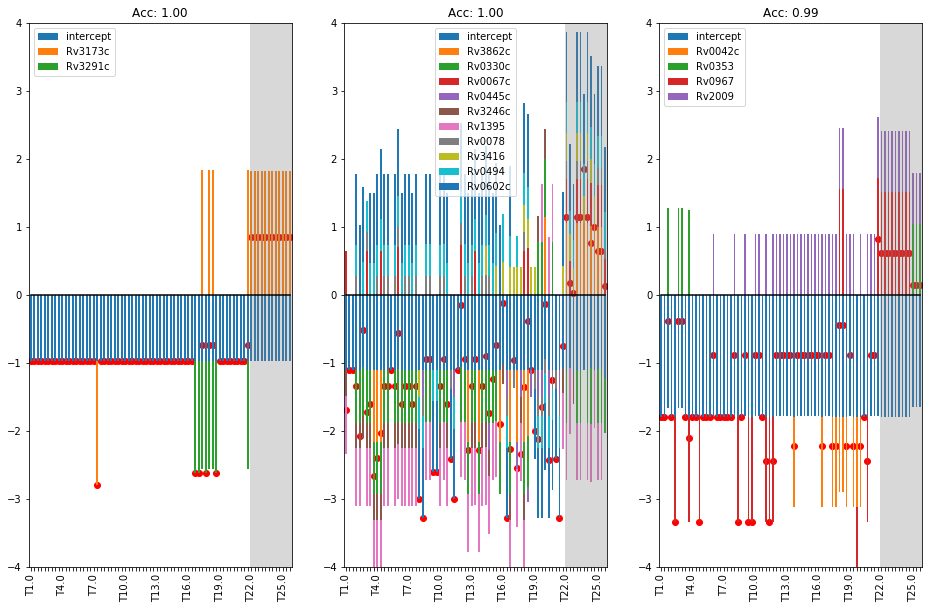

In [4]:
for state in STATES:
    plotProfile(state)

## Instance Evaluation

In [5]:
 def fullProfile(ser_X, title=""):
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            collection = COLLECTION_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            collection.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = "State %d" % idx,
                label_xoffset=label_xoffset)
        fig.suptitle(title, fontsize=16)
        plt.show()

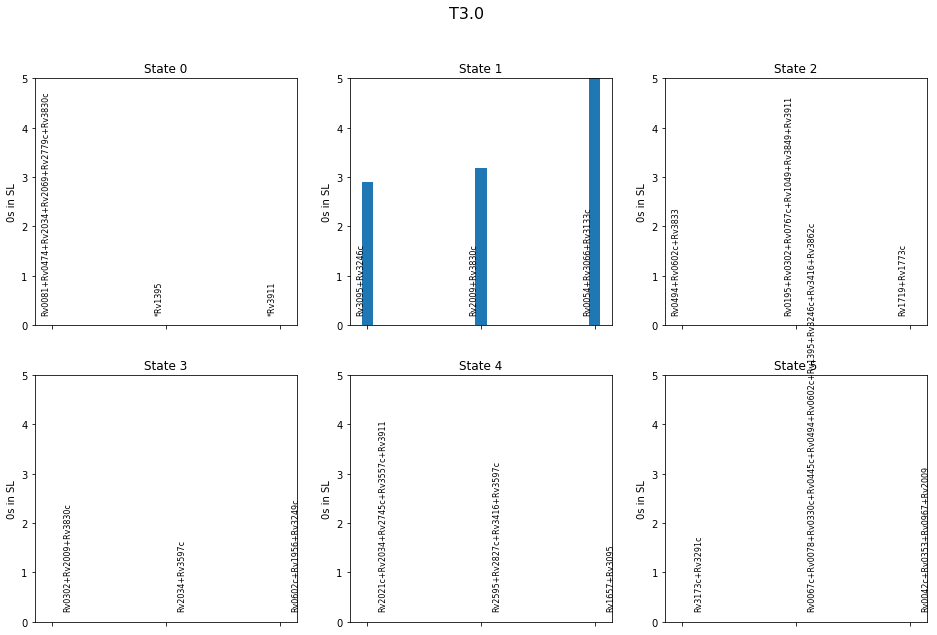

In [6]:
instance = "T3.0"
ser_X = DF_X.loc[instance]
fullProfile(ser_X, title=instance)